In [1]:
# imports

import os
import re
import math
import random
from datetime import datetime
import numpy as np
from typing import Optional
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
from huggingface_hub import login
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset, DatasetDict
from concurrent.futures import ProcessPoolExecutor
from transformers import AutoTokenizer
from items import Item, read_dataset
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o-mini"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)
PHI3 = "microsoft/Phi-3-medium-4k-instruct"
GEMMA = "google/gemma-2-9b-it"

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/ed/.cache/huggingface/token
Login successful


In [4]:
%matplotlib inline

In [5]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"

In [6]:
dataset_names = [
    "Clothing_Shoes_and_Jewelry",
    "Beauty_and_Personal_Care",
    "Health_and_Household",
    "Home_and_Kitchen",
    "Sports_and_Outdoors",
    "Automotive",
    "Electronics",
    "Industrial_and_Scientific",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Patio_Lawn_and_Garden",
    "Cell_Phones_and_Accessories",
    "Pet_Supplies",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [7]:
start = datetime.now()
items = []
with ProcessPoolExecutor(max_workers=7) as pool:
    for results in pool.map(read_dataset, dataset_names):
        items.extend(results)
finish = datetime.now()
print(f"Completed in {(finish-start).total_seconds()/60:.1f} mins")

Loading dataset Electronics
Loading dataset Health_and_Household
Loading dataset Beauty_and_Personal_Care
Loading dataset Home_and_Kitchen
Loading dataset Sports_and_Outdoors
Loading dataset Clothing_Shoes_and_Jewelry
Loading dataset Automotive
Completed loading Health_and_Household with 228,837 datapoints
Loading dataset Industrial_and_Scientific
Completed loading Beauty_and_Personal_Care with 232,785 datapoints
Loading dataset Office_Products
Completed loading Sports_and_Outdoors with 328,634 datapoints
Loading dataset Tools_and_Home_Improvement
Completed loading Industrial_and_Scientific with 138,854 datapoints
Loading dataset Patio_Lawn_and_Garden
Completed loading Electronics with 403,002 datapoints
Loading dataset Cell_Phones_and_Accessories
Completed loading Office_Products with 205,498 datapoints
Loading dataset Pet_Supplies
Completed loading Pet_Supplies with 117,657 datapoints
Loading dataset Toys_and_Games
Completed loading Patio_Lawn_and_Garden with 258,605 datapoints
Loadi

In [8]:
len(items)

5509774

In [9]:
max(item.token_count for item in items)

351

In [ ]:
with open('items2.pkl', 'wb') as file:
    pickle.dump(items, file)

In [ ]:
with open('items2.pkl', 'rb') as file:
    items = pickle.load(file)

In [11]:
items = [i for i in items if i.token_count<=350]

In [12]:
len(items)

5509772

In [13]:
# Let's investigate:

print(f"There are {len(items):,} items with prices\n")
print(items[5000000].prompt)

There are 5,509,772 items with prices

<|begin_of_text|>Question: how much does this cost to the nearest dollar?

Title: Tan Sand Beige - Butterfly Boho Insect Flower PopSockets Swappable PopGrip
Details: PopGrip with swappable top; switch out your PopTop for another design or remove it completely for wireless charging capabilities. (Not compatible with Apple MagSafe wireless charger or MagSafe wallet.) Expandable stand to watch videos, take group photos, FaceTime, and Skype handsfree. Advanced adhesive allows you to remove and reposition on most devices and cases. Note Will not stick to some silicone, waterproof, or highly textured cases. Works best with smooth, hard plastic cases. Will adhere to iPhone 11, but not to the iPhone 11 Pro nor the iPhone 11 ProMax without a suitable case. Dimensions 4.3 x 3.4 x 0.3 inches, Weight 0.48 ounces, model number 260027, Rank Cell Phones & Accessories 764029, Cell Phone Stands 79752, Special features Expandable,Waterproof,Wireless Charger,Wireles

Average length is 1,404.6 and highest length is 2,307



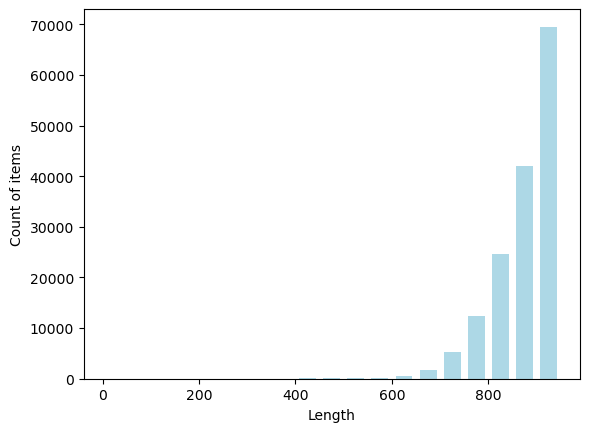

In [14]:
# Plot the distribution of character count

lengths = [len(item.prompt) for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Length')
ax.set_ylabel('Count of items');
_ = ax.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 1000, 50))

print(f"Average length is {sum(lengths)/len(lengths):,.1f} and highest length is {max(lengths):,}\n")

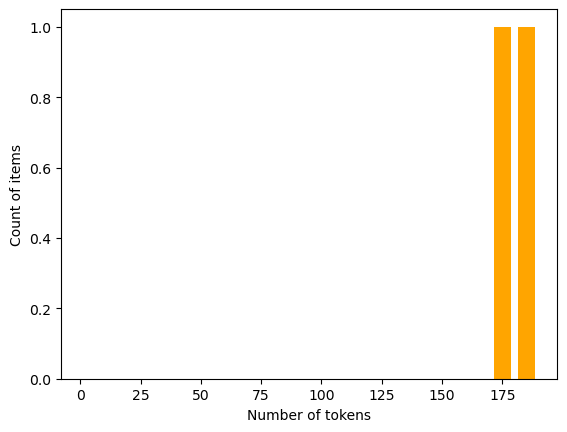

In [15]:
# Plot the distribution of tokens

token_counts = [item.token_count for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of items');
_ = ax.hist(token_counts, rwidth=0.7, color="orange", bins=range(0, 200, 10))

In [16]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [17]:
report(items[0])

<|begin_of_text|>Question: how much does this cost to the nearest dollar?

Title: SAS Women's, Relaxed Sandal
Details: Unwind, leave your worries behind, and simply relax and enjoy the comfort of the versatile Relaxed sandal. Premium leather uppers in a casual sandal silhouette. Offers three-point adjustability with durable buckles at each strap. Features Ultra-Puff(TM) cushioned linings that protect the foot with Super Soft topline construction that eliminates harsh edges against the foot Made in the USA Suede sole Heel measures approximately 1.5 inches COMFY FOOTWEAR Unwind, leave your worries behind, and simply relax and enjoy the comfort of the versatile SAS Relaxed sandal with pemium leather uppers in a casual sandal silhouette CUSHION LININGS It features Ultra-Puff cushioned linings that protect the foot with Super Soft topline construction eliminating harsh edges against the foot SHOCK ABSORPTION A broad, contoured footbed features soft Super Suede linings that molds to the natu

Average price is $51.13 and highest price is $999.49



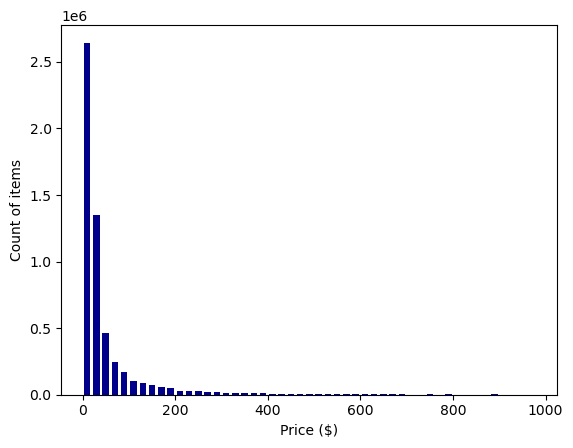

In [18]:
# Plot the distribution of prices

prices = [float(item.price) for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Count of items');
_ = ax.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 20))

print(f"Average price is ${sum(prices)/len(prices):.2f} and highest price is ${max(prices):,.2f}\n")

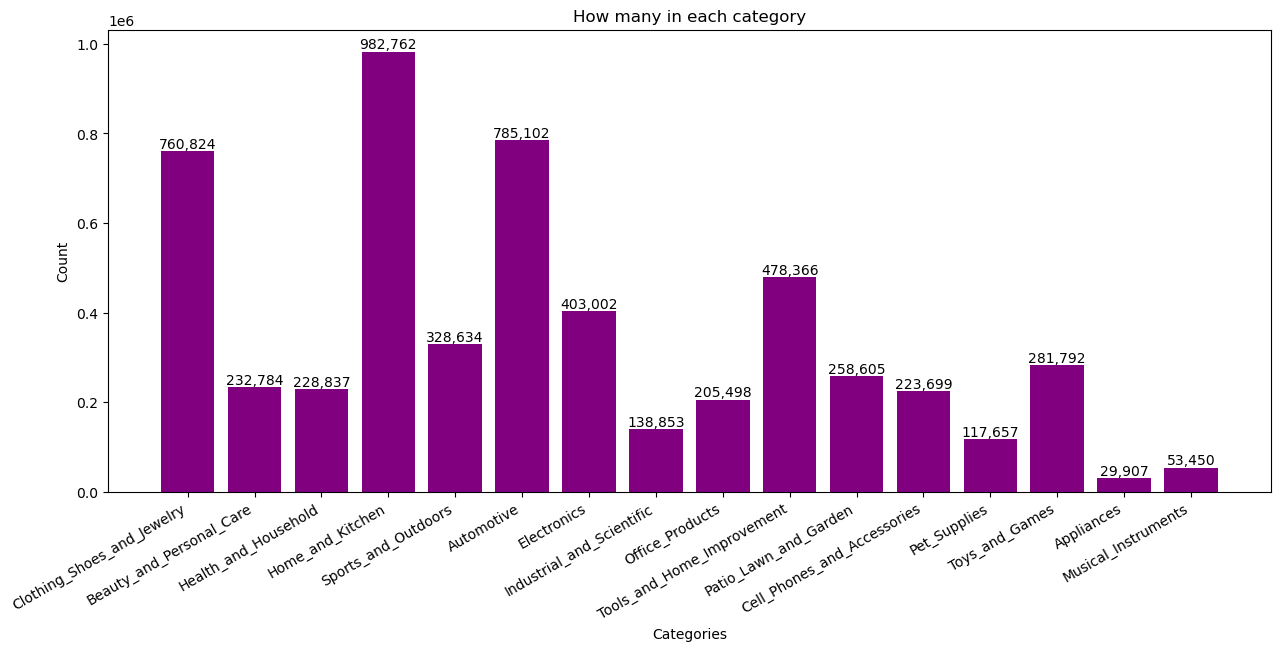

In [19]:
from collections import Counter
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="purple")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [20]:
from collections import defaultdict
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

print(f"\nMinimum: {min([len(slot) for slot in slots.values()]):,}")


Minimum: 8


In [43]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=350:
        sample.extend(slot)
    elif len(slot) <= 960:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 3 if item.category=='Home_and_Kitchen' else 8 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=960, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)
len(sample)

404011

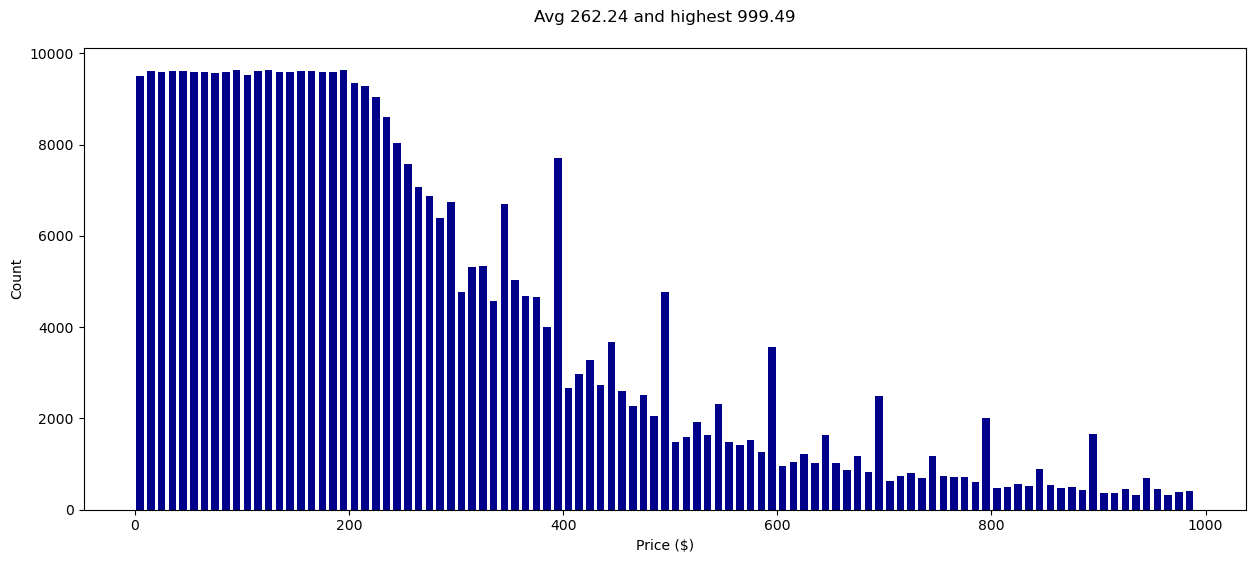

In [44]:
# Plot the distribution of prices

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

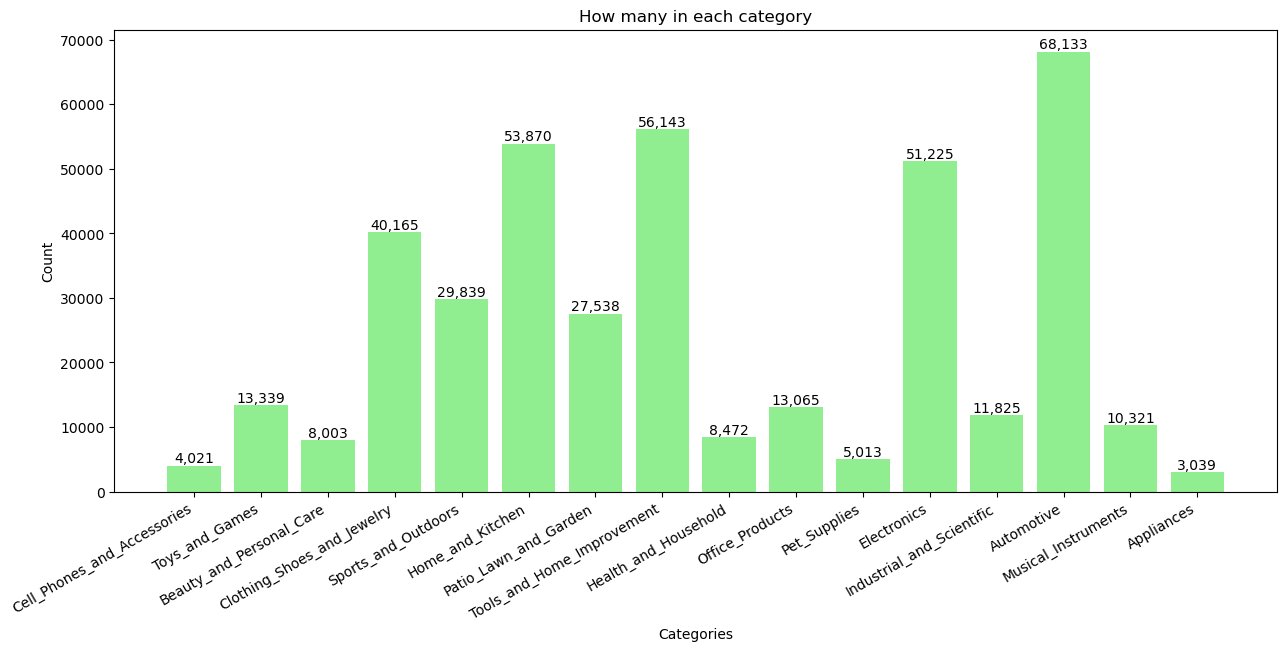

In [45]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [46]:
report(sample[400000])

<|begin_of_text|>Question: how much does this cost to the nearest dollar?

Title: Classic Hoyer Lift C-HLA
Details: The Classic Hoyer Lift is an economical homecare patient lift with a 400-lb weight capacity. The narrow 24 leg width makes getting into tight spots easier than other Patient Lifts. For more than 50 years, Hoyer lifters have defined the lifter category. From Ted Hoyer's early designs in the 1950's to more efficient models built with modern designs and materials, the Hoyer name has always stood for innovation. Today's lifters use state-of-the-art ergonomic design and quality components. The result's a lifter that you can always depend on. The Classic Hoyer Lift has proven to be a durable patient lifter that has assisted patient transferring for over forty years. The Classic Hoyer Lift's chrome finish and adjustable U-base has set the standard for lifters in both clinical and homecare settings. This easy to operate hydraulic pump lifter enhances smooth transferring that surp

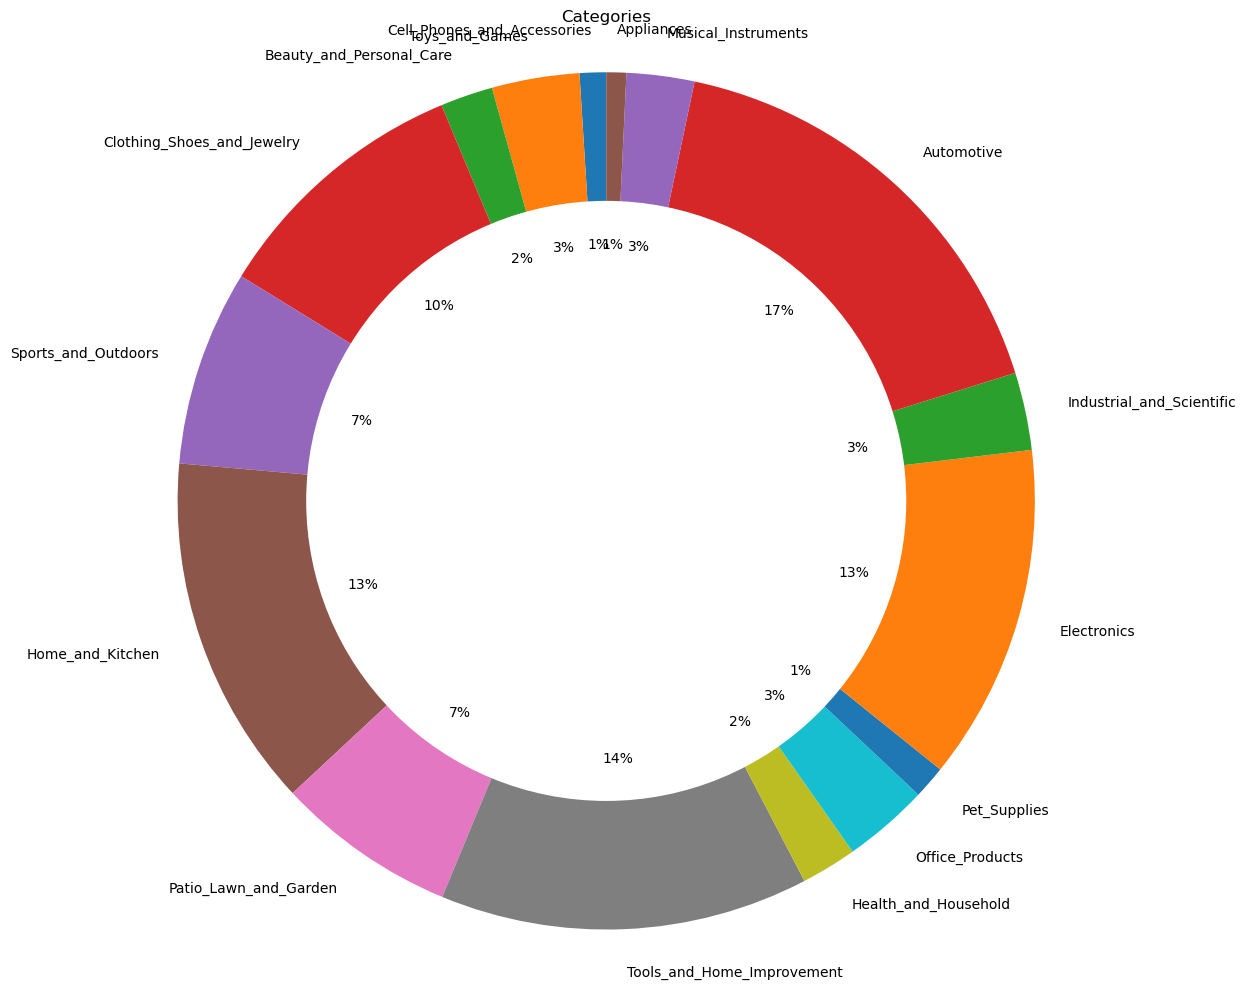

In [47]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Customize the chart
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Display the chart
plt.tight_layout()
plt.show()

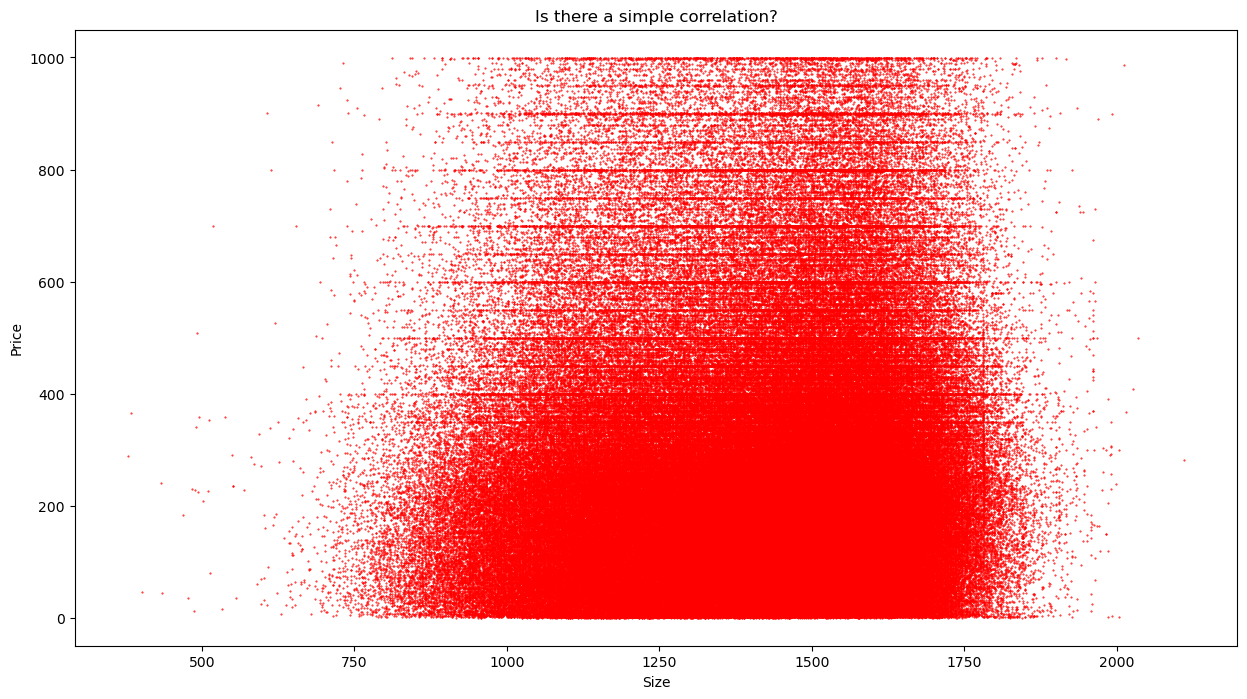

In [48]:
sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

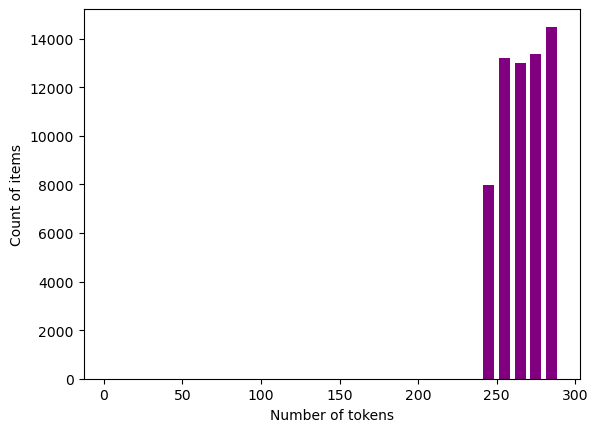

In [49]:
# Plot the distribution again to check it looks as expected

token_counts = [item.token_count for item in sample]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of items');
_ = ax.hist(token_counts, rwidth=0.7, color="purple", bins=range(0, 300, 10))

In [50]:
report(sample[-2])

<|begin_of_text|>Question: how much does this cost to the nearest dollar?

Title: LAVA ME 3 38 Carbon Fiber Lightweight Guitar for Right Hand with Effects Acoustic Guitar Soft | Support Wi-Fi Bluetooth | with Space Bag, Bundle with HogoR Guitar Pick
Details: The FreeBoost Technology uses the back of the LAVA ME 3 guitar as a speaker Multi-touch Screen & HILAVA System with powerful built-in apps (including Tuner, Metronome, various Effects, Trainer, Rhythm Tracks, Looper & Recorder) WIFI & Bluetooth connectivity; Top HPL (high pressure laminate); Back & Sides HPL (high pressure laminate) Neck HPL (high pressure laminate); Fingerboard HPL (high pressure laminate); 18 Frets Nut TUSQ; Nut Width 42,9 mm (1,69 ); Scale 597 mm (23,5 ); Bridge Material High Performance Fiber Composite ; Pre-Amp L3 Smart Preamp w. Freeboost 2.2 Technology Effects App and Loops App You can start playing instantly with the quick access to Tuner, Tempo, Effects, and Loops apps on the lock- screen. The Effects app 

In [51]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


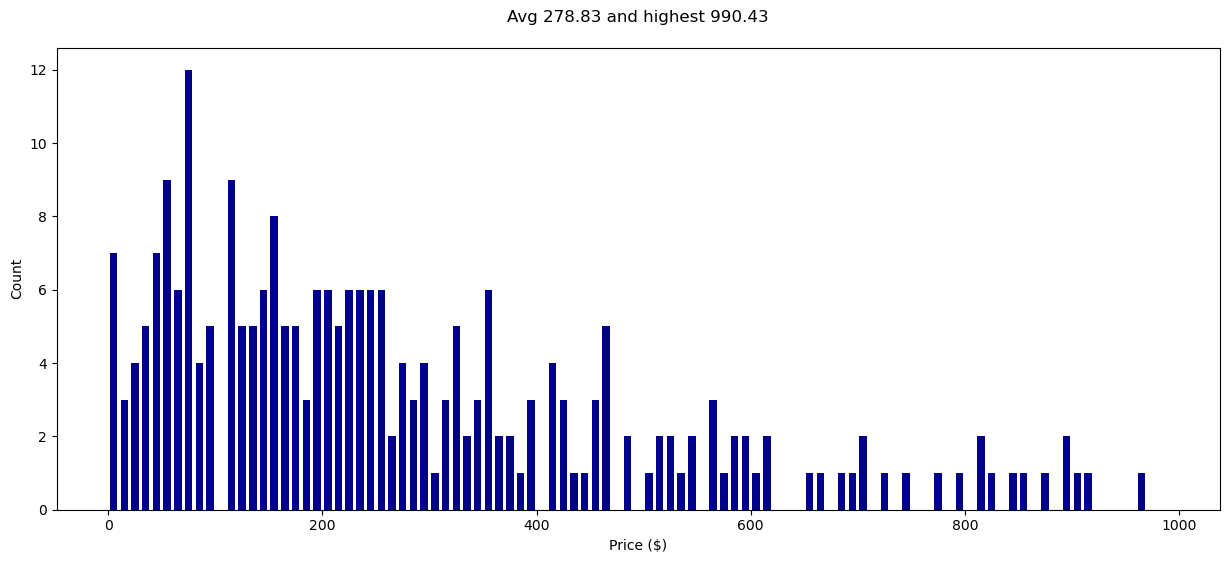

In [52]:
# Plot the distribution of prices

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [ ]:
del items, slots
import gc
gc.collect()

In [ ]:
import csv
with open('test.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:200]:
        writer.writerow([t.title, t.details, 0])

In [ ]:
human_predictions = []
with open('human.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[2]))

In [ ]:
average = sum(t.price for t in train)/len(train)
average

In [53]:
class TestRunner:

    def __init__(self, predictor, data, title, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = RED if error>=40 else YELLOW if error>=20 else GREEN
        color_str = "red" if error>=40 else "yellow" if error>=20 else "green"
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color_str)
        print(f"{color}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = [e for e in self.errors if e<20]
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={len(hits)/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()
        return self

In [54]:
train_average = sum(t.price for t in train)/len(train)

def flat_predictor(item):
    return train_average

1: Guess: $262.18 Truth: $225.66 Error: $36.52 SLE: 0.02 Item: Generation Lighting 6639003-962 Three Li...
2: Guess: $262.18 Truth: $82.99 Error: $179.19 SLE: 1.30 Item: Paradise Found Men's Bamboo Paradise Shi...
3: Guess: $262.18 Truth: $799.99 Error: $537.81 SLE: 1.24 Item: Dell Latitude 3420 3000 14" FHD IPS (Int...
4: Guess: $262.18 Truth: $419.66 Error: $157.48 SLE: 0.22 Item: Delta Faucet T17T238-RB Lahara Tempassur...
5: Guess: $262.18 Truth: $116.94 Error: $145.24 SLE: 0.64 Item: 1 3/4" Smooth A153-D HOT DIP Coil Roofin...
6: Guess: $262.18 Truth: $666.30 Error: $404.12 SLE: 0.87 Item: TOTO TLG02307U#CP Single Handle Vessel B...
7: Guess: $262.18 Truth: $191.99 Error: $70.19 SLE: 0.10 Item: DELSEY Paris Chatelet 2.0 Weekender Trav...
8: Guess: $262.18 Truth: $243.53 Error: $18.65 SLE: 0.01 Item: Yellow Jacket 46010 Brute II 4-Valve Man...
9: Guess: $262.18 Truth: $89.64 Error: $172.54 SLE: 1.14 Item: éS Stylus Mid
10: Guess: $262.18 Truth: $458.56 Error: $196.38 SLE: 0.31 Item

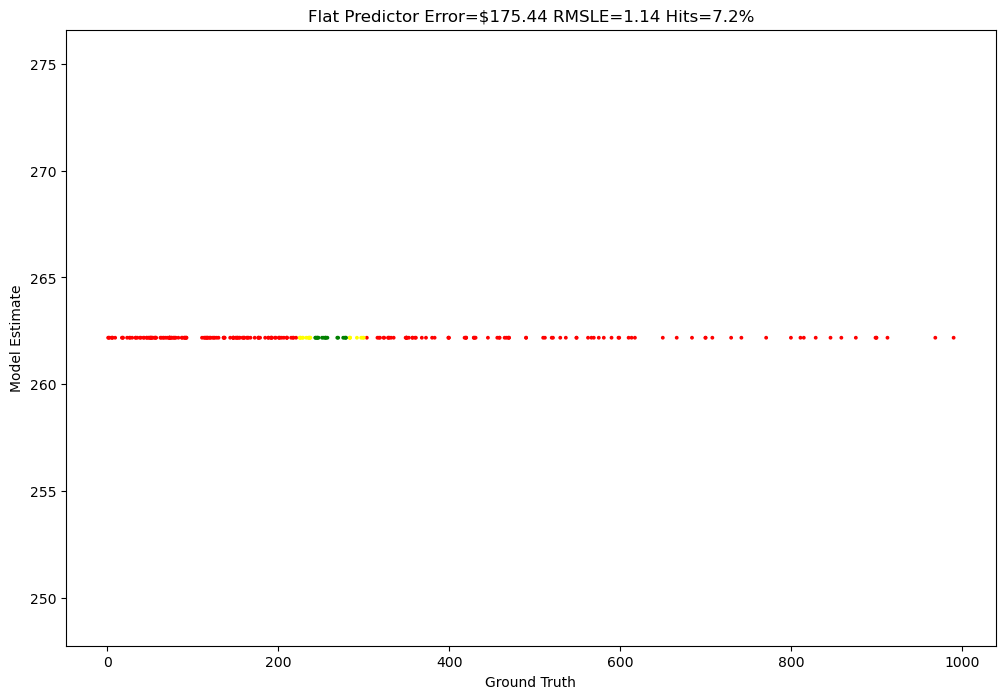

In [55]:
runner = TestRunner(flat_predictor, test, "Flat Predictor").run()

In [ ]:
human_predictions = []
with open('human.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[2]))

def human_predictor(item):
    index = test.index(item)
    if index==-1:
        raise ValueError("Index not found")
    return human_predictions[index]

In [ ]:
runner = TestRunner(human_predictor, test, "Human Predictor").run()

In [ ]:
stop = set(['the', 'and', 'for', 'is', 'to', 'this', 'with', 'a', 'of', 'your', 'are', 'in','from', 'you', 'or', 'an', 'on', 'by'])

def words(item):
  text = f"{item.title} {item.details}"
  text = re.sub(r'[\(\)\[\]\{\},\'"\- \s]+', ' ', text)
  words = text.strip().lower().split(' ')
  filtered = [word for word in words if word not in stop]
  return " ".join(filtered)

In [ ]:
documents = [words(item) for item in train]
from collections import Counter
count = Counter()
for doc in documents:
    ws = doc.split(" ")
    for w in ws:
        count[w]+=1
count.most_common(30)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np

np.random.seed(42)

labels = np.array([float(item.price) for item in train])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

regressor = LinearRegression()
regressor.fit(X, labels)

In [ ]:
def linear_regression_predictor(item):
    np.random.seed(42)
    x = vectorizer.transform([words(item)])
    return max(regressor.predict(x)[0], 0)

In [ ]:
runner1 = TestRunner(linear_regression_predictor, test, "Linear Regression").run()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR

np.random.seed(42)

labels = np.array([float(item.price) for item in train])

vectorizer = TfidfVectorizer(max_features=20)
X = vectorizer.fit_transform(documents)

regressor = SVR(kernel='linear')
regressor.fit(X, labels)

In [ ]:
def svr_predictor(item):
    np.random.seed(42)
    x = vectorizer.transform([words(item)])
    return max(regressor.predict(x)[0], 0)

In [ ]:
runner2 = TestRunner(svr_predictor, test, "SVR Accuracy").run()

In [64]:
def messages_for(item):
    system_message = "You estimate prices of items under $1000. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().split('>')[1]
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt}
    ]

In [66]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [67]:
def gpt_predictor(item):
    response = openai.chat.completions.create(
        model=OPENAI_MODEL, #"gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=6
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $290.00 Truth: $225.66 Error: $64.34 SLE: 0.06 Item: Generation Lighting 6639003-962 Three Li...
2: Guess: $85.00 Truth: $82.99 Error: $2.01 SLE: 0.00 Item: Paradise Found Men's Bamboo Paradise Shi...
3: Guess: $899.00 Truth: $799.99 Error: $99.01 SLE: 0.01 Item: Dell Latitude 3420 3000 14" FHD IPS (Int...
4: Guess: $290.00 Truth: $419.66 Error: $129.66 SLE: 0.14 Item: Delta Faucet T17T238-RB Lahara Tempassur...
5: Guess: $25.00 Truth: $116.94 Error: $91.94 SLE: 2.29 Item: 1 3/4" Smooth A153-D HOT DIP Coil Roofin...
6: Guess: $329.00 Truth: $666.30 Error: $337.30 SLE: 0.50 Item: TOTO TLG02307U#CP Single Handle Vessel B...
7: Guess: $160.00 Truth: $191.99 Error: $31.99 SLE: 0.03 Item: DELSEY Paris Chatelet 2.0 Weekender Trav...
8: Guess: $279.00 Truth: $243.53 Error: $35.47 SLE: 0.02 Item: Yellow Jacket 46010 Brute II 4-Valve Man...
9: Guess: $90.00 Truth: $89.64 Error: $0.36 SLE: 0.00 Item: éS Stylus Mid
10: Guess: $309.00 Truth: $458.56 Error: $149.56 SLE: 0.15 Item: Lokar A

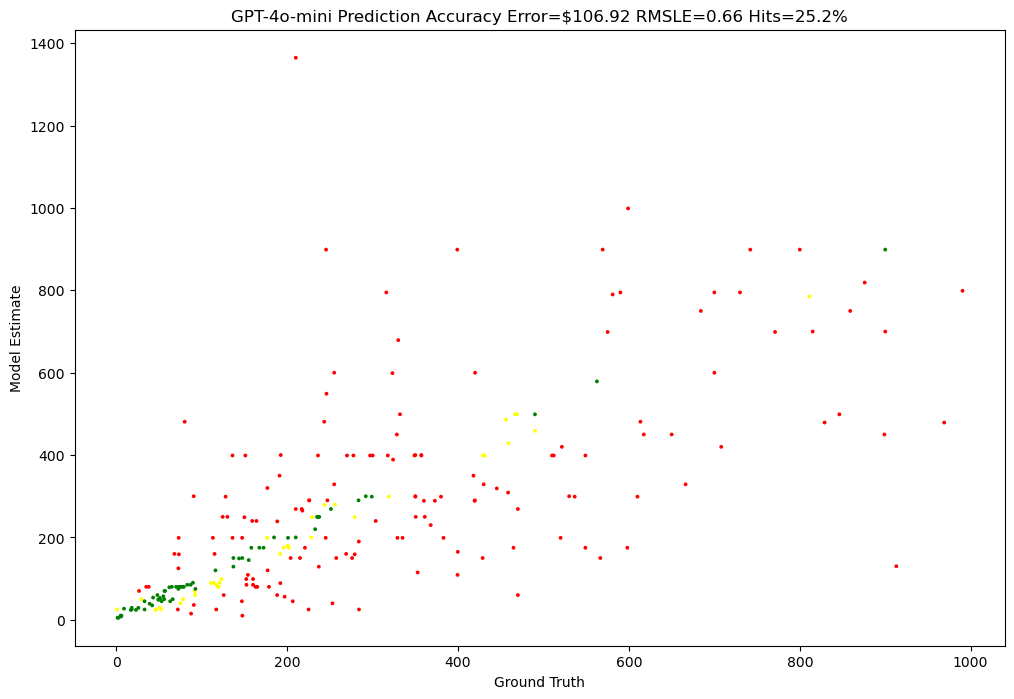

In [68]:
runner = TestRunner(gpt_predictor, test, "GPT-4o-mini Prediction Accuracy").run()

In [ ]:
runner.title = "GPT-4o Frontier 2024-08-06"
runner.report()

In [69]:
def frontier_predictor(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=6
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $195.00 Truth: $225.66 Error: $30.66 SLE: 0.02 Item: Generation Lighting 6639003-962 Three Li...
2: Guess: $85.00 Truth: $82.99 Error: $2.01 SLE: 0.00 Item: Paradise Found Men's Bamboo Paradise Shi...
3: Guess: $850.00 Truth: $799.99 Error: $50.01 SLE: 0.00 Item: Dell Latitude 3420 3000 14" FHD IPS (Int...
4: Guess: $290.00 Truth: $419.66 Error: $129.66 SLE: 0.14 Item: Delta Faucet T17T238-RB Lahara Tempassur...
5: Guess: $42.00 Truth: $116.94 Error: $74.94 SLE: 1.02 Item: 1 3/4" Smooth A153-D HOT DIP Coil Roofin...
6: Guess: $250.00 Truth: $666.30 Error: $416.30 SLE: 0.96 Item: TOTO TLG02307U#CP Single Handle Vessel B...
7: Guess: $220.00 Truth: $191.99 Error: $28.01 SLE: 0.02 Item: DELSEY Paris Chatelet 2.0 Weekender Trav...
8: Guess: $215.00 Truth: $243.53 Error: $28.53 SLE: 0.02 Item: Yellow Jacket 46010 Brute II 4-Valve Man...
9: Guess: $80.00 Truth: $89.64 Error: $9.64 SLE: 0.01 Item: éS Stylus Mid
10: Guess: $309.00 Truth: $458.56 Error: $149.56 SLE: 0.15 Item: Lokar A

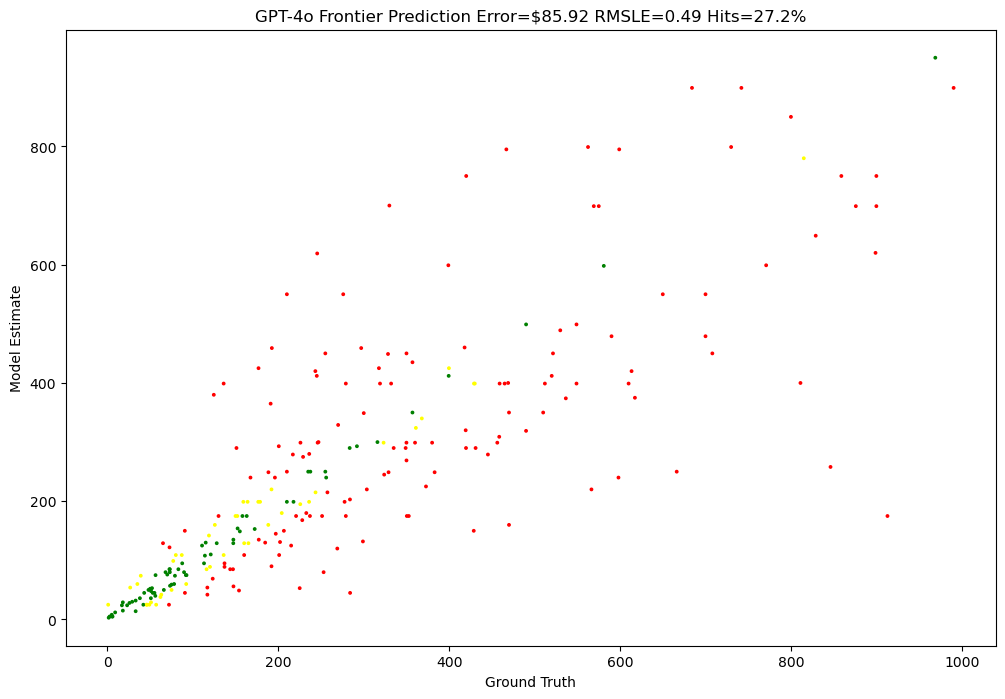

In [70]:
runner = TestRunner(frontier_predictor, test, "GPT-4o Frontier Prediction").run()

In [83]:
bos = "<|begin_of_text|>"
eos = "<|end_of_text|>"
def clean(text):
    return text.replace(bos, "").replace(eos, "")

In [84]:
train_prompts = [clean(item.prompt) for item in train]
train_prices = [item.price for item in train]
test_prompts = [clean(item.test_prompt()) for item in test]
test_prices = [item.price for item in test]

In [85]:
train_prompts[1]

"Question: how much does this cost to the nearest dollar?\n\nTitle: IRON COMPANY Body-Solid Commercial Bench/Squat Rack Combo Package\nDetails: Designed with an extra-wide 4-point stance, the SDIB370 is a rock-solid performer that features a 7 degree reverse pitch that accommodates your body's natural lifting path. Lift-off and safety positions are right where you want the so racking the bar is always comfortable and predictable. Perform squats, calf raises, lunges, dead-lifts, upright rows, and many, many more power building exercises. Weight plates, bar, and collars as shown in manufacturer stock photo are for demonstration purposes only and are NOT included. 14-position gun rack can handle over 1,000 lbs. and gives the user the ability to walk the bar up and down without removing plates. Features 4 Olympic storage posts that suspend weight plates for quick and easy access while keeping your workout area organized. Back pad adjusts flat, incline (15, 30, 45, 60 and 80 degrees) and de

In [86]:
# Create a Dataset from the lists
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [87]:
DATASET_NAME = "ed-donner/pricer-large-dataset"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/200 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/200 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ed-donner/pricer-large-dataset/commit/a448c676365e4c1df467dfc5d10e38b76743def5', commit_message='Upload dataset', commit_description='', oid='a448c676365e4c1df467dfc5d10e38b76743def5', pr_url=None, pr_revision=None, pr_num=None)